## Sentiment Analysis With Basic Neural Network

Using imdb movie reviews dataset, we will train a basic ANN to predict the sentiment of Warren Buffett's annual 'Letter to Shareholders'.

In [29]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import regex as re
from sklearn.model_selection import train_test_split

# Load IMDB dataset
dataset = tfds.load('imdb_reviews', split='train')
dataframe = tfds.as_dataframe(dataset)

# Decode each text and put into pandas df
imdb_df = pd.DataFrame()
regexes = (("<", ""), ("br", "", ), ("/>", ""), ("  ", " "))
reviews = []
for text in dataframe['text']:
    text = text.decode()
    for reg in regexes:
        text = re.sub(reg[0], reg[1], text)
    reviews.append(text)
imdb_df['text'] = reviews
imdb_df['label'] = dataframe['label']

# Split data into training and validation
train_X, test_X, train_y, test_y = train_test_split(imdb_df['text'].values, imdb_df['label'].values, test_size=0.2)

2023-06-28 10:24:24.507510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-06-28 10:24:24.507775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


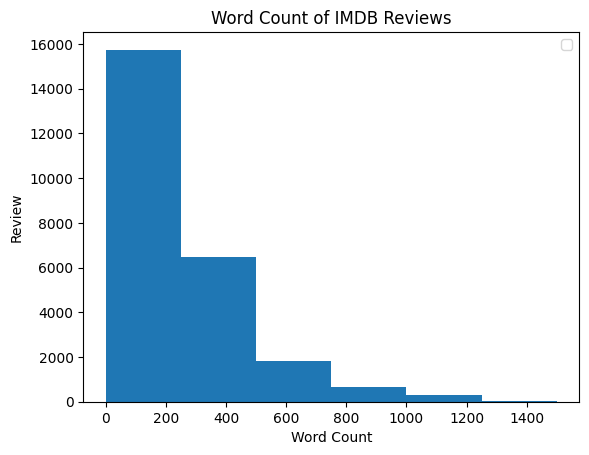

In [30]:
import matplotlib.pyplot as plt
import nltk

# Tokenize each review
tokenized_reviews = []   
for text in imdb_df['text']:
    text = nltk.word_tokenize(text)
    tokenized_reviews.append(text)

# Add to new df
df_tok = pd.DataFrame()
df_tok['text'] = tokenized_reviews

# Plot hist of word counts
fig = plt.figure()
ax = fig.add_subplot()
ax.hist([len(text) for text in df_tok['text']], [0, 250, 500, 750, 1000, 1250, 1500])
ax.set_title('Word Count of IMDB Reviews')
ax.set_xlabel('Word Count')
ax.set_ylabel('Review')
ax.legend()

IMDB reviews are much shorter than the letters we are trying to predict the sentiment of. Therefore, we will train the ANN to predict the sentiment of individual sentences and then use the average sentiment of all sentences in a letter to predict the overall sentiment of the letter.

In [31]:
from keras.layers import TextVectorization

# Parameters for vocab size and number of words in a sequence
vocab_size = 10000
seq_len = 250  # Rough average of word count

# Use TextVectorization to turn strings into vectors of integers
vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size, 
    output_mode='int',
    output_sequence_length=seq_len)

# Build vocabulary
all_reviews = imdb_df['text'].values
vectorize_layer.adapt(all_reviews)

In [32]:
# Build model
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

# Train model
model.fit(train_X, train_y, epochs=30)
history = model.history

Epoch 1/30
625/625 [==============================] - 2s 3ms/step - loss: 0.5762 - accuracy: 0.7537
Epoch 2/30
625/625 [==============================] - 2s 3ms/step - loss: 0.3152 - accuracy: 0.8783
Epoch 3/30
625/625 [==============================] - 2s 3ms/step - loss: 0.2406 - accuracy: 0.9082
Epoch 4/30
625/625 [==============================] - 2s 3ms/step - loss: 0.2005 - accuracy: 0.9258
Epoch 5/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1703 - accuracy: 0.9372
Epoch 6/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1463 - accuracy: 0.9478
Epoch 7/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1264 - accuracy: 0.9576
Epoch 8/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1085 - accuracy: 0.9650
Epoch 9/30
625/625 [==============================] - 2s 3ms/step - loss: 0.0931 - accuracy: 0.9722
Epoch 10/30
625/625 [==============================] - 2s 3ms/step - loss: 0.0815 - accuracy: 0.9755

Text(0, 0.5, 'Loss')

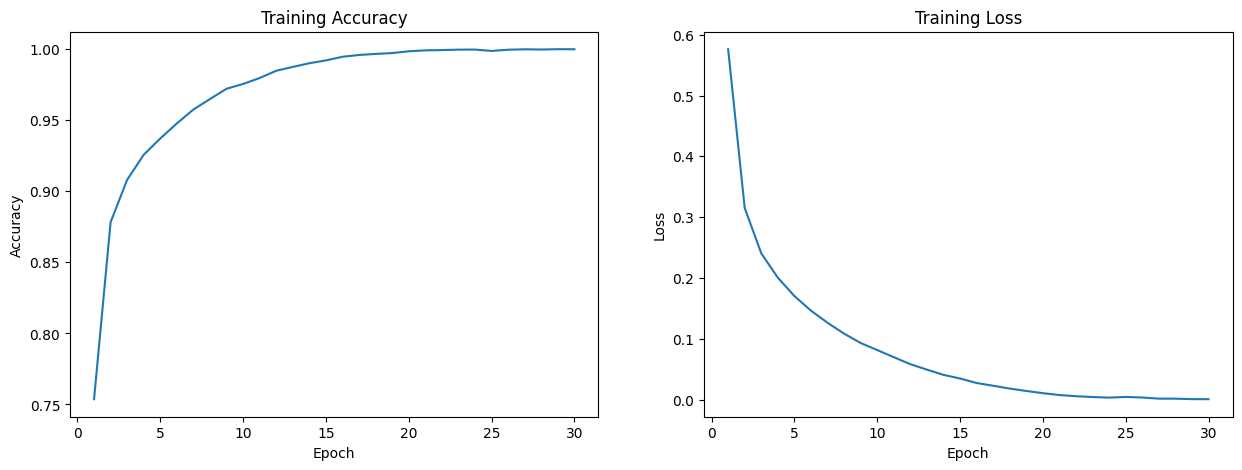

In [33]:
# Graph training accuracy and loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
epochs = [i for i in range(1, len(history.history['loss'])+1)]
axes[0].plot(epochs, history.history['accuracy'], label='traning accuracy')
axes[0].set_title('Training Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[1].plot(epochs, history.history['loss'], label='loss')
axes[1].set_title('Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

In [34]:
# Load buffett letters
letters = []
with open('data/letters.txt', 'r', encoding='utf8') as file:
    for count, line in enumerate(file):

        # Split letter into list of sentences and remove figures
        sents = nltk.sent_tokenize(line)
        for sent in sents:
            if (re.search("\.\.\.\.\.", sent)) is not None:  # Figures indicated by long elipses
                del sents[sents.index(sent)]
            if (re.search("\. \. \. \. ", sent)) is not None:  # 21st letter has spaces inbetween periods
                del sents[sents.index(sent)]
        letters.append(sents)

In [35]:
# Read sp500 data, reverse indices, and start at 1977
sp500 = pd.read_csv('data/sp500.csv')
sp500 = sp500.iloc[::-1]
sp500 = sp500[sp500['year'] >= 1978]
sp500 = sp500.reset_index()

# Load letters and SP500 performance into df
df = pd.DataFrame()
df['Year'] = [i for i in range(1977, 2022)]
df['Letter'] = letters
df['SP500 Year After'] = sp500['performance']
df.head()

,Year,Letter,SP500 Year After
0,1977,[To the Stockholders of Berkshire Hathaway Inc...,6.56
1,1978,[To the Shareholders of Berkshire Hathaway Inc...,18.44
2,1979,[To the Shareholders of Berkshire Hathaway Inc...,32.42
3,1980,[To the Shareholders of Berkshire Hathaway Inc...,-4.91
4,1981,[To the Shareholders of Berkshire Hathaway Inc...,21.55


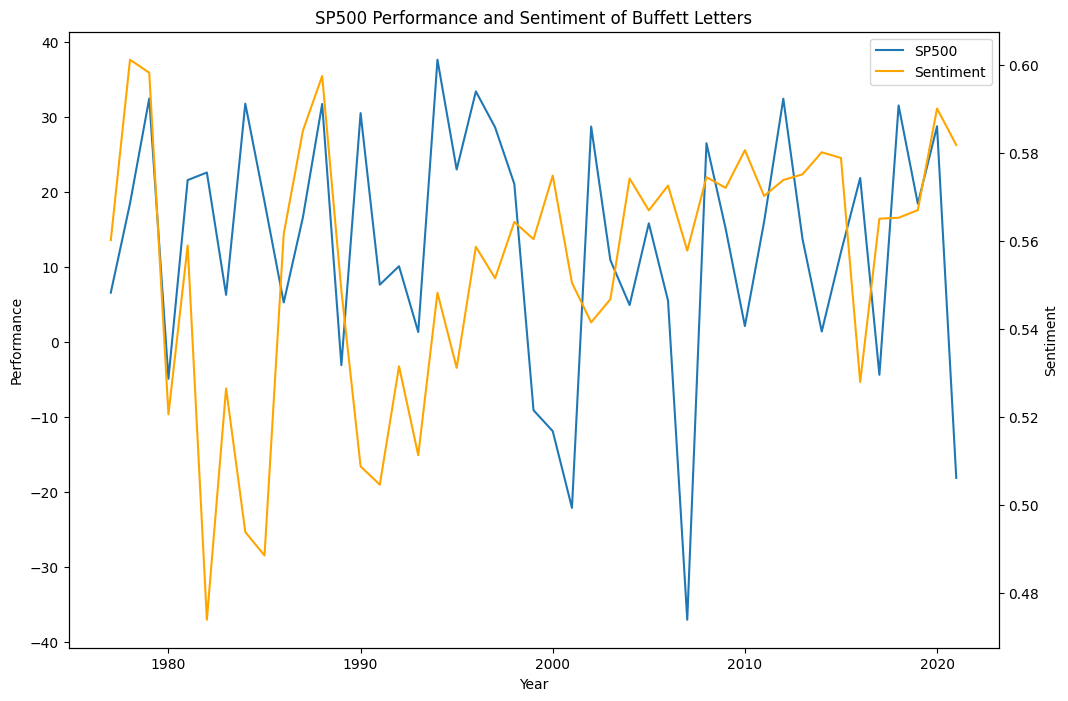

In [42]:
# Predict sentiment of each letter
sentiments = []
for letter in letters:
    preds = model.predict(letter, verbose=0)
    sentiments.append(preds.mean())

# Add sentiments to df
df['Sentiment'] = sentiments

# Plot SP500 performance and sentiment
fig, ax = plt.subplots()
fig.set_figheight(8), fig.set_figwidth(12)
ax.plot(df['Year'], df['SP500 Year After'], label='SP500')
ax.set_title('SP500 Performance and Sentiment of Buffett Letters')
ax.set_xlabel('Year')
ax.set_ylabel('Performance')
ax2 = ax.twinx()
ax2.plot(df['Year'], df['Sentiment'], color='orange', label='Sentiment')
ax2.set_ylabel('Sentiment')

# Add legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

Very basic network (one embedding layer, one pooling layer, one hidden layer) shows that the sentiment of the letter sometimes correlates with the SP500 performance of the year after the letter was written, but does not match that well overall.